이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 RNN을 이용하여 텍스트 생성하기의 튜토리얼입니다.  

링크 : https://wikidocs.net/45101

2021년 10월 13일에 테스트되었습니다.

## **08-06 RNN을 이용한 텍스트 생성(Text Generation using RNN)**

### **1. RNN을 이용하여 텍스트 생성하기**

예를 들어서 '경마장에 있는 말이 뛰고 있다'와 '그의 말이 법이다'와 '가는 말이 고와야 오는 말이 곱다'라는 세 가지 문장이 있다고 해봅시다. 모델이 문맥을 학습할 수 있도록 전체 문장의 앞의 단어들을 전부 고려하여 학습하도록 데이터를 재구성한다면 아래와 같이 총 11개의 샘플이 구성됩니다

| samples |            X             |    y   |
|:-------:|:-------------------------|:-------|
|    1    | 경마장에                   | 있는    |
|    2    | 경마장에 있는              | 말이    |
|    3    | 경마장에 있는 말이         | 뛰고    |
|    4    | 경마장에 있는 말이 뛰고    | 있다    |
|    5    | 그의                       | 말이    |
|    6    | 그의 말이                  | 법이다  |
|    7    | 가는                       | 말이    |
|    8    | 가는 말이                  | 고와야  |
|    9    | 가는 말이 고와야           | 오는    |
|   10    | 가는 말이 고와야 오는      | 말이    |
|   11    | 가는 말이 고와야 오는 말이 | 곱다    |



#### **1) 데이터에 대한 이해와 전처리**

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

우선 예제로 언급한 3개의 한국어 문장을 저장합니다.

In [4]:
text = """경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""
text

'경마장에 있는 말이 뛰고 있다\n\n그의 말이 법이다\n\n가는 말이 고와야 오는 말이 곱다\n'

단어 집합을 생성하고 크기를 확인해보겠습니다. 단어 집합의 크기를 저장할 때는 **케라스 토크나이저** 의 **정수 인코딩** 은 인덱스가 1부터 시작하지만, **패딩** 을 위한 0을 고려하여 +1을 해줍니다.

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])  # 반드시 리스트 안에 넣어서 입력
vocab_size = len(tokenizer.word_index) + 1   # padding할 때 맨 앞자리를 0으로 하기 위함 (인덱스를 맞춤)
vocab_size  # 단어 집합의 크기

12

각 단어와 단어에 부여된 정수 인덱스를 출력해보겠습니다.

In [6]:
print(tokenizer.word_index)

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [7]:
print(tokenizer.index_word)

{1: '말이', 2: '경마장에', 3: '있는', 4: '뛰고', 5: '있다', 6: '그의', 7: '법이다', 8: '가는', 9: '고와야', 10: '오는', 11: '곱다'}


훈련 데이터를 만들어보겠습니다.

In [8]:
# 문장 토큰화
text.split('\n'), len(text.split('\n'))

(['경마장에 있는 말이 뛰고 있다', '', '그의 말이 법이다', '', '가는 말이 고와야 오는 말이 곱다', ''], 6)

In [9]:
line = text.split('\n')[0]
line

'경마장에 있는 말이 뛰고 있다'

In [10]:
## 정수인코딩
tokenizer.texts_to_sequences([line])

[[2, 3, 1, 4, 5]]

In [11]:
sequences = list()
for line in text.split('\n'):       # \n을 기준으로 문장 토큰화
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]    # 문장의 시작부터 i번째 단어까지의 시퀀스
        sequences.append(sequence)

print('@@@@ 학습에 사용할 샘플의 개수: %d' % len(sequences))

@@@@ 학습에 사용할 샘플의 개수: 11


샘플의 개수는 총 11개가 나옵니다. 전체 샘플을 출력해봅시다.

In [12]:
sequences

[[2, 3],
 [2, 3, 1],
 [2, 3, 1, 4],
 [2, 3, 1, 4, 5],
 [6, 1],
 [6, 1, 7],
 [8, 1],
 [8, 1, 9],
 [8, 1, 9, 10],
 [8, 1, 9, 10, 1],
 [8, 1, 9, 10, 1, 11]]

| samples |            X             |    y   |
|:-------:|:-------------------------|:-------|
|    1    | 경마장에                   | 있는    |
|    2    | 경마장에 있는              | 말이    |
|    3    | 경마장에 있는 말이         | 뛰고    |
|    4    | 경마장에 있는 말이 뛰고    | 있다    |
|    5    | 그의                       | 말이    |
|    6    | 그의 말이                  | 법이다  |
|    7    | 가는                       | 말이    |
|    8    | 가는 말이                  | 고와야  |
|    9    | 가는 말이 고와야           | 오는    |
|   10    | 가는 말이 고와야 오는      | 말이    |
|   11    | 가는 말이 고와야 오는 말이 | 곱다    |

위의 데이터는 아직 레이블로 사용될 단어를 분리하지 않은 훈련 데이터입니다. [2, 3]은 [경마장에, 있는]에 해당되며 [2, 3, 1]은 [경마장에, 있는, 말이]에 해당됩니다. 전체 훈련 데이터에 대해서 맨 우측에 있는 단어에 대해서만 레이블로 분리해야 합니다.

우선 전체 샘플에 대해서 길이를 일치시켜 줍니다. 가장 긴 샘플의 길이를 기준으로 합니다. 현재 육안으로 봤을 때, 길이가 가장 긴 샘플은 [8, 1, 9, 10, 1, 11]이고 길이는 6입니다. 이를 코드로는 다음과 같이 구할 수 있습니다.

In [13]:
max_len = max(len(l) for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 6


전체 훈련 데이터에서 가장 긴 샘플의 길이가 6임을 확인하였습니다. 전체 샘플의 길이를 6으로 패딩합니다.

In [14]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')

pad_sequences()는 모든 샘플에 대해서 0을 사용하여 길이를 맞춰줍니다. maxlen의 값으로 6을 주면 모든 샘플의 길이를 6으로 맞춰주며, **padding** 의 인자로 `'pre'`를 주면 길이가 6보다 짧은 샘플의 앞에 0으로 채웁니다. 전체 훈련 데이터를 출력해봅니다.

In [15]:
sequences

array([[ 0,  0,  0,  0,  2,  3],
       [ 0,  0,  0,  2,  3,  1],
       [ 0,  0,  2,  3,  1,  4],
       [ 0,  2,  3,  1,  4,  5],
       [ 0,  0,  0,  0,  6,  1],
       [ 0,  0,  0,  6,  1,  7],
       [ 0,  0,  0,  0,  8,  1],
       [ 0,  0,  0,  8,  1,  9],
       [ 0,  0,  8,  1,  9, 10],
       [ 0,  8,  1,  9, 10,  1],
       [ 8,  1,  9, 10,  1, 11]])

길이가 6보다 짧은 모든 샘플에 대해서 앞에 0을 채워서 모든 샘플의 길이를 6으로 바꿨습니다. 이제 각 샘플의 마지막 단어를 레이블로 분리합시다. 레이블의 분리는 Numpy를 이용해서 가능합니다. 리스트의 마지막 값을 제외하고 저장한 것은 X, 리스트의 마지막 값만 저장한 것은 y. 이는 레이블에 해당됩니다.

In [24]:
X = sequences[:, :-1]
y = sequences[:, -1]

분리된 X와 y에 대해서 출력해보면 다음과 같습니다.

In [25]:
X

array([[ 0,  0,  0,  0,  2],
       [ 0,  0,  0,  2,  3],
       [ 0,  0,  2,  3,  1],
       [ 0,  2,  3,  1,  4],
       [ 0,  0,  0,  0,  6],
       [ 0,  0,  0,  6,  1],
       [ 0,  0,  0,  0,  8],
       [ 0,  0,  0,  8,  1],
       [ 0,  0,  8,  1,  9],
       [ 0,  8,  1,  9, 10],
       [ 8,  1,  9, 10,  1]])

In [26]:
y

array([ 3,  1,  4,  5,  1,  7,  1,  9, 10,  1, 11])

레이블이 분리되었습니다. RNN 모델에 훈련 데이터를 훈련 시키기 전에 레이블에 대해서 **원-핫 인코딩** 을 수행합니다.

In [ ]:
# y = to_categorical(y, num_classes=vocab_size)  # One Hot Encoding을 안할 경우 loss func : sparse_categrical_crossentropy
# # to_categorical(y)

원-핫 인코딩이 수행되었는지 출력합니다.

In [28]:
vocab_size

12

In [29]:
y.shape, y

((11,), array([ 3,  1,  4,  5,  1,  7,  1,  9, 10,  1, 11]))

하이퍼파라미터인 **임베딩 벡터의 차원** 은 10, **은닉 상태의 크기** 는 32입니다. **다 대 일 구조** 의 RNN을 사용합니다. **전결합층(Fully Connected Layer)** 을 출력층으로 단어 집합 크기만큼의 뉴런을 배치하여 모델을 설계합니다. 해당 모델은 마지막 시점에서 **모든 가능한 단어 중 하나의 단어를 예측하는 다중 클래스 분류 문제** 를 수행하는 모델입니다. 다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용하여 200 에포크를 수행합니다.

In [22]:
vocab_size

12

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

embedding_dim = 10  # 임베딩 벡터의 크기
hidden_units = 32   # 히든 벡터의 크기

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))    # (12, 10) : 임베딩도 학습
model.add(SimpleRNN(hidden_units))

In [31]:
vocab_size

12

In [30]:
model.add(Dense(vocab_size, activation='softmax'))      # One-Hot (단어 사전의 크기와 동일)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1818 - loss: 2.4890
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2727 - loss: 2.4747
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2727 - loss: 2.4604
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2727 - loss: 2.4460
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2727 - loss: 2.4315
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3636 - loss: 2.4166
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3636 - loss: 2.4014
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4545 - loss: 2.3857
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5455 - loss: 2.3695
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4545 - loss: 2.3527
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4545 - loss: 2.3352
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4545 - loss

<Axes: >

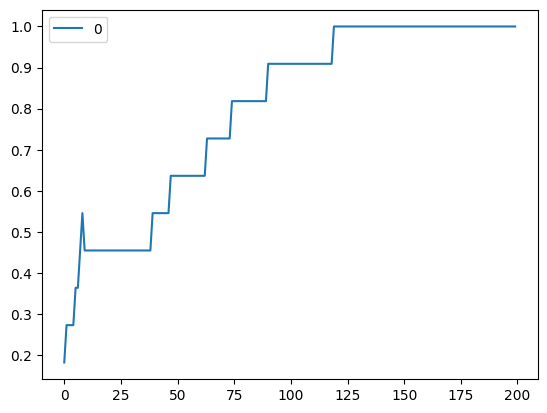

In [32]:
import pandas as pd 
pd.DataFrame(history.history['accuracy']).plot()

<Axes: >

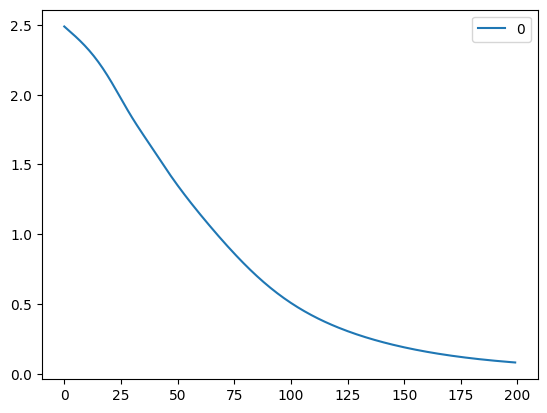

In [33]:
pd.DataFrame(history.history['loss']).plot()

In [36]:
tokenizer.index_word

{1: '말이',
 2: '경마장에',
 3: '있는',
 4: '뛰고',
 5: '있다',
 6: '그의',
 7: '법이다',
 8: '가는',
 9: '고와야',
 10: '오는',
 11: '곱다'}

모델이 정확하게 예측하고 있는지 문장을 생성하는 함수를 만들어서 출력해봅시다.

In [42]:
## 문장 생성 함수
def sentence_generation(model, tokenizer, current_word, n): # 모델, 기학습된 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        # 현재 단어에 대한 정수 인코딩과 패딩
        encoded = tokenizer.texts_to_sequences([current_word])[0]    # 정수인코딩 
        encoded = pad_sequences([encoded], maxlen=5, padding='pre')  # 학습데이터의 padding 5
        
        # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        print(result.round(3))
        result = np.argmax(result, axis=1) # 예측한 단어의 인덱스
        print(result)
        # 위의 코드 대체
        word = tokenizer.index_word[result[0]] # 예측한 단어의 인덱스를 단어로 변환 (result는 list)

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word
        
        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

입력된 단어로부터 다음 단어를 예측해서 문장을 생성하는 함수를 만들었습니다. '경마장에' 라는 단어 뒤에는 총 4개의 단어가 있으므로 4번 예측해봅시다.

In [43]:
print(sentence_generation(model, tokenizer, '경마장에', 6))   # 단어 6개 생성성

[[0.004 0.142 0.005 0.796 0.    0.002 0.003 0.028 0.001 0.009 0.009 0.   ]]
[3]
[[0.001 0.982 0.001 0.008 0.    0.001 0.    0.001 0.    0.004 0.    0.   ]]
[1]
[[0.001 0.    0.    0.    0.95  0.002 0.001 0.023 0.001 0.004 0.003 0.013]]
[4]
[[0.001 0.008 0.001 0.002 0.006 0.964 0.001 0.004 0.001 0.    0.01  0.   ]]
[5]
[[0.03  0.51  0.047 0.055 0.003 0.127 0.035 0.003 0.032 0.149 0.    0.009]]
[1]
[[0.002 0.    0.003 0.001 0.014 0.001 0.009 0.013 0.004 0.003 0.028 0.922]]
[11]
경마장에 있는 말이 뛰고 있다 말이 곱다


In [33]:
10 * 32 + 32*32 + 32

1376

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 5, 10)          │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,678 (22.18 KB)

 Trainable params: 1,892 (7.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,786 (14.79 KB)

In [44]:
sentence = ''
current_word= '경마장에'
init_word = current_word

## 학습시 만든 tokenizer로 정수 인코딩 실시
encoded = tokenizer.texts_to_sequences([current_word])[0]
encoded

[2]

In [46]:
## 패딩
encoded = pad_sequences([encoded], maxlen=5, padding='pre')
encoded  # ' 경마장에'를 원핫인코딩한 단어 -> 문장 차원으로 (2차원 X 데이터)

array([[0, 0, 0, 0, 2]])

In [47]:
# 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측한 단어)를 result에 저장.
result = model.predict(encoded, verbose=1)
result.shape, result.round(3)   # 다음에 나올 단어 (예측)  : 단어사전 크기 12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


((1, 12),
 array([[0.004, 0.142, 0.005, 0.796, 0.   , 0.002, 0.003, 0.028, 0.001,
         0.009, 0.009, 0.   ]], dtype=float32))

In [48]:
result = np.argmax(result, axis=1)
result

array([3], dtype=int64)

In [49]:
tokenizer.index_word

{1: '말이',
 2: '경마장에',
 3: '있는',
 4: '뛰고',
 5: '있다',
 6: '그의',
 7: '법이다',
 8: '가는',
 9: '고와야',
 10: '오는',
 11: '곱다'}

In [50]:
tokenizer.index_word[result[0]]

'있는'

In [51]:
for word, index in tokenizer.word_index.items():
    # 만약 예측한 단어의 인덱스와 동일한 단어가 있다면 break
    if index == result:
        break

# 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
current_word = current_word + ' '  + word
current_word

'경마장에 있는'

In [42]:
# 예측 단어를 문장에 저장
sentence = sentence + ' ' + word
sentence

' 있는'

In [43]:
sentence = init_word + sentence
sentence

'경마장에 있는'

In [45]:
print(sentence_generation(model, tokenizer, '그의', 5))

[1]
[7]
[1]
[4]
[5]
그의 말이 법이다 말이 뛰고 있다


In [46]:
print(sentence_generation(model, tokenizer, '가는', 10))

[1]
[9]
[10]
[1]
[11]
[10]
[1]
[11]
[10]
[1]
가는 말이 고와야 오는 말이 곱다 오는 말이 곱다 오는 말이


앞의 문맥을 기준으로 '말이' 라는 단어 다음에 나올 단어를 기존의 훈련 데이터와 일치하게 예측함을 보여줍니다. 이 모델은 충분한 훈련 데이터를 갖고 있지 못하므로 위에서 문장의 길이에 맞게 적절하게 예측해야하는 횟수 4, 2, 5를 각각 인자값으로 주었습니다. 이 이상의 숫자를 주면 기계는 '있다', '법이다', '곱다' 다음에 나오는 단어가 무엇인지 배운 적이 없으므로 임의 예측을 합니다. 이번에는 더 많은 훈련 데이터를 가지고 실습해봅시다.

### **2. LSTM을 이용하여 텍스트 생성하기**

이번에는 LSTM을 통해 보다 많은 데이터로 텍스트를 생성해보겠습니다. 본질적으로 앞에서 한 것과 동일한 실습입니다.

#### **1) 데이터에 대한 이해와 전처리**
사용할 데이터는 뉴욕 타임즈 기사의 제목입니다. 아래의 링크에서 ArticlesApril2018.csv 데이터를 다운로드 합니다.

파일 다운로드 링크 : https://www.kaggle.com/aashita/nyt-comments

In [1]:
import pandas as pd
import numpy as np
from string import punctuation

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

다운로드한 훈련 데이터를 데이터프레임에 저장합니다.

In [2]:
df = pd.read_csv('dataset/ArticlesApril2018.csv')
df

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,5ae82c93068401528a2ab969,1004,By CLAIRE CAIN MILLER,article,This Common Question Reinforces the Gender Pay...,"['Discrimination', 'Wages and Salaries', 'Labo...",68,Upshot,3,2018-05-01 09:00:01,Unknown,Several states and cities have ordered employe...,The New York Times,News,https://www.nytimes.com/2018/05/01/upshot/how-...
1320,5ae82c95068401528a2ab96b,1043,By TRACY J. GATES,article,"Anna, Llama and Me","['Friendship', 'Dewdney, Anna', 'Writing and W...",65,Well,0,2018-05-01 09:00:02,Family,"The beginning, middle and end of a picture boo...",The New York Times,News,https://www.nytimes.com/2018/05/01/well/family...
1321,5ae82c9d068401528a2ab96d,659,Interview by AUDIE CORNISH,article,Gen. Michael Hayden Has One Regret: Russia,"['Classified Information and State Secrets', '...",66,Magazine,70,2018-05-01 09:00:06,Unknown,"The former N.S.A. and C.I.A. chief on Trump, S...",The New York Times,News,https://www.nytimes.com/2018/05/01/magazine/ge...
1322,5ae82c9f068401528a2ab96f,1155,By JASON ROBERT BROWN,article,There Is Nothin’ Like a Tune,"['Books and Literature', 'Purdum, Todd S', 'Th...",68,BookReview,17,2018-05-01 09:00:07,Book Review,"In “Something Wonderful,” Todd S. Purdum analy...",The New York Times,Review,https://www.nytimes.com/2018/05/01/books/revie...


열의 개수가 굉장히 많기 때문에 한 눈에 보기 어렵습니다. 어떤 열이 있고, 열이 총 몇 개가 있는지 출력해봅시다.

In [56]:
print('열의 개수: ', len(df.columns))
df.columns

열의 개수:  15


Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')

총 15개의 열이 존재합니다. 여기서 사용할 열은 제목에 해당되는 headline 열입니다. Null 값이 있는지 확인해봅시다.

In [57]:
df['headline'].isnull().values.any()   # Null 없음

False

Null 값은 별도로 없는 것으로 보입니다. headline 열에서 모든 신문 기사의 제목을 뽑아서 하나의 리스트로 저장해보도록 하겠습니다.

In [58]:
headline = df.headline.values
headline.shape, headline[:5]

((1324,),
 array(['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
        'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
        'The New Noma, Explained', 'Unknown', 'Unknown'], dtype=object))

headline이라는 리스트에 모든 신문 기사의 제목을 저장했습니다. 저장한 리스트에서 상위 5개만 출력해보았습니다.

네번째와 다섯 번째 샘플에 Unknown 값이 들어가있습니다. headline 전체에 걸쳐서 Unknown 값을 가진 샘플이 있을 것으로 추정됩니다. 비록 Null 값은 아니지만 실습에 도움이 되지 않는 노이즈 데이터이므로 제거해줄 필요가 있습니다. 제거하기 전에 현재 샘플의 개수를 확인해보고 제거 전, 후의 샘플의 개수를 비교해봅시다.

In [59]:
print('총 샘플의 개수 : {}'.format(len(headline))) # 현재 샘플의 개수

총 샘플의 개수 : 1324


노이즈 데이터를 제거하기 전 신문 기사의 제목 샘플은 총 1,324개입니다. Unknown 값을 가진 샘플을 제거합니다.

In [60]:
 # Unknown 값을 가진 샘플 제거
headline = [word for word in headline if word != "Unknown"]
print('노이즈값 제거 후 샘플의 개수 : {}'.format(len(headline)))

노이즈값 제거 후 샘플의 개수 : 1214


샘플의 수가 1,324에서 1,214로 110개의 샘플이 제거되었는데 기존에 출력했던 5개의 샘플을 출력해봅시다.

In [62]:
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

기존에 네번째, 다섯 번째 샘플에서는 Unknown 값이 있었는데 현재는 제거가 되었습니다. 이제 데이터 전처리를 수행합니다. 여기서 선택한 전처리는 **구두점 제거와 단어의 소문자** 화입니다. 전처리를 수행하고, 다시 샘플 5개를 출력합니다.

In [63]:
def repreprocessing(raw_sentence):
    preproceseed_sentence = raw_sentence.encode("utf8").decode("ascii",'ignore')
    # 구두점 제거와 동시에 소문자화
    return ''.join(word for word in preproceseed_sentence if word not in punctuation).lower()

preporcessed_headline = [repreprocessing(x) for x in headline]
preporcessed_headline[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

기존의 출력과 비교하면 모든 단어들이 소문자화되었으며 N.F.L.이나 Cheerleaders’ 등과 같이 기존에 구두점이 붙어있던 단어들에서 구두점이 제거되었습니다. 단어 집합(vocabulary)을 만들고 크기를 확인합니다.

In [64]:
tokenizer = Tokenizer()   # 띄어쓰기 단위 토큰화 
tokenizer.fit_on_texts(preporcessed_headline)  # 단어사전 만들기
vocab_size = len(tokenizer.word_index) + 1     # padding시 0번 인덱스에 0 채움
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 3494


In [65]:
tokenizer.word_index ## 단어 사전

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'for': 6,
 'and': 7,
 'is': 8,
 'on': 9,
 'with': 10,
 'trump': 11,
 'as': 12,
 'at': 13,
 'new': 14,
 'how': 15,
 'from': 16,
 'it': 17,
 'an': 18,
 'that': 19,
 'be': 20,
 'season': 21,
 'us': 22,
 'you': 23,
 'its': 24,
 'what': 25,
 'episode': 26,
 'can': 27,
 'your': 28,
 'not': 29,
 'he': 30,
 'now': 31,
 'his': 32,
 'are': 33,
 'teaching': 34,
 'war': 35,
 'out': 36,
 'no': 37,
 'was': 38,
 'by': 39,
 'trumps': 40,
 'has': 41,
 'over': 42,
 'may': 43,
 'into': 44,
 'why': 45,
 'more': 46,
 'we': 47,
 'who': 48,
 'about': 49,
 'recap': 50,
 'activities': 51,
 '1': 52,
 'just': 53,
 'do': 54,
 'women': 55,
 'when': 56,
 'syria': 57,
 'trade': 58,
 'i': 59,
 '2': 60,
 'or': 61,
 'will': 62,
 'this': 63,
 'have': 64,
 'president': 65,
 'but': 66,
 'home': 67,
 'up': 68,
 'long': 69,
 'one': 70,
 'off': 71,
 'facebook': 72,
 'house': 73,
 'gop': 74,
 'our': 75,
 'case': 76,
 'they': 77,
 'life': 78,
 'end': 79,
 'right': 80,
 'some':

총 3,494개의 단어가 존재합니다. 정수 인코딩을 진행하는 동시에 하나의 문장을 여러 줄로 분해하여 훈련 데이터를 구성합니다.

In [66]:
sequences = list()

for sentence in preporcessed_headline:

    # 각 샘플에 대한 정수 인코딩
    encoded = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:20]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3],
 [100, 3, 1117],
 [100, 3, 1117, 2],
 [100, 3, 1117, 2, 14],
 [100, 3, 1117, 2, 14, 583],
 [100, 3, 1117, 2, 14, 583, 24],
 [100, 3, 1117, 2, 14, 583, 24, 1118],
 [100, 3, 1117, 2, 14, 583, 24, 1118, 373],
 [100, 3, 1117, 2, 14, 583, 24, 1118, 373, 374],
 [100, 3, 1117, 2, 14, 583, 24, 1118, 373, 374, 5]]

이해를 돕기 위해 출력 결과에 주석을 추가하였습니다. 왜 하나의 문장을 저렇게 나눌까요? 예를 들어 '경마장에 있는 말이 뛰고 있다' 라는 문장 하나가 있을 때, 최종적으로 원하는 훈련 데이터의 형태는 다음과 같습니다. 하나의 단어를 예측하기 위해 이전에 등장한 단어들을 모두 참고하는 것입니다.
  

  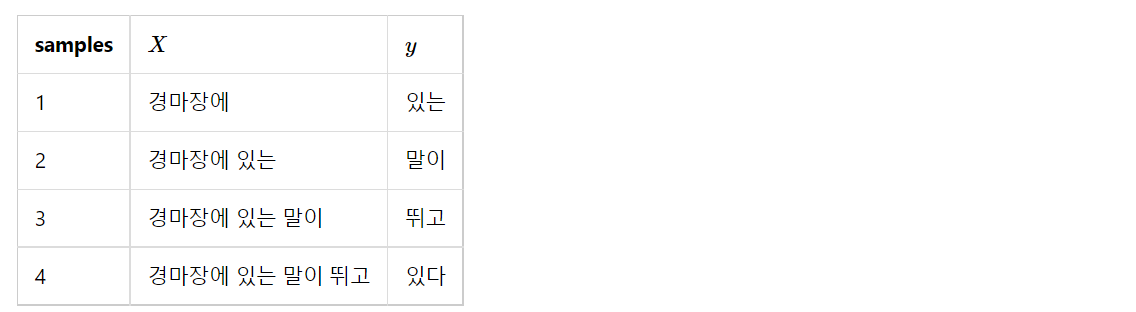

위의 sequences는 모든 문장을 각 단어가 각 시점(time step)마다 하나씩 추가적으로 등장하는 형태로 만들기는 했지만, 아직 예측할 단어에 해당되는 레이블을 분리하는 작업까지는 수행하지 않은 상태입니다. 어떤 정수가 어떤 단어를 의미하는지 알아보기 위해 인덱스로부터 단어를 찾는 index_to_word를 만듭니다.

In [67]:
# index_to_word = {}
# for key, value in tokenizer.word_index.items(): # 인덱스를 단어로 바꾸기 위해 index_to_word를 생성
#     index_to_word[value] = key
index_to_word = tokenizer.index_word

print('빈도수 상위 582번 단어 : {}'.format(index_to_word[582]))

빈도수 상위 582번 단어 : offer


582이라는 인덱스를 가진 단어는 본래 offer라는 단어였습니다. 원한다면 다른 숫자로도 시도해보세요. 이제 데이터를 분리하기 전에 전체 샘플의 길이를 동일하게 만드는 패딩 작업을 수행합니다. 패딩 작업을 수행하기 전에 가장 긴 샘플의 길이를 확인합니다.

In [68]:
max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 24


가장 긴 샘플의 길이인 24로 모든 샘플의 길이를 패딩하겠습니다.

In [69]:
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:20])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   99  269  371 1115  582]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0   99  269  371 1115  582   52]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0   99  269  371 1115  582   52    7]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   99  269  371 1115  582   52    7    2]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0   99  269  371 1115  582   52    7    2  372]


padding='pre'를 설정하여 샘플의 길이가 24보다 짧은 경우에 앞에 0으로 패딩되었습니다. 이제 **맨 우측 단어만 레이블로 분리** 합니다.

In [76]:
# X, Y 데이터 분리 (교사 강요!)
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [77]:
print(X[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  99]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 269]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  99 269 371]]


훈련 데이터 X에서 3개의 샘플만 출력해보았는데, 맨 우측에 있던 정수값 269, 371, 1115가 사라진 것을 볼 수 있습니다. 뿐만 아니라, 각 샘플의 길이가 24에서 23으로 줄었습니다.

In [78]:
print(y[:3])

[ 269  371 1115]


훈련 데이터 y 중 3개의 샘플만 출력해보았는데, 기존 훈련 데이터에서 맨 우측에 있던 정수들이 별도로 저장되었습니다.

In [ ]:
# y = to_categorical(y, num_classes=vocab_size)

In [79]:
y[:3]

array([ 269,  371, 1115])

레이블 데이터 y에 대해서 원-핫 인코딩을 수행하였습니다. 이제 모델을 설계합니다.

#### **2) 모델 설계하기**

RNN 모델에 데이터를 훈련시킵니다.

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

하이퍼파라미터인 **임베딩 벡터의 차원은 10, 은닉 상태의 크기는 128** 입니다. **다 대 일 구조의 LSTM** 을 사용합니다. **전결합층(Fully Connected Layer)을 출력층으로** 단어 집합 크기만큼의 뉴런을 배치하여 모델을 설계합니다. 해당 모델은 마지막 시점에서 모든 가능한 단어 중 하나의 단어를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용하여 200 에포크를 수행합니다.

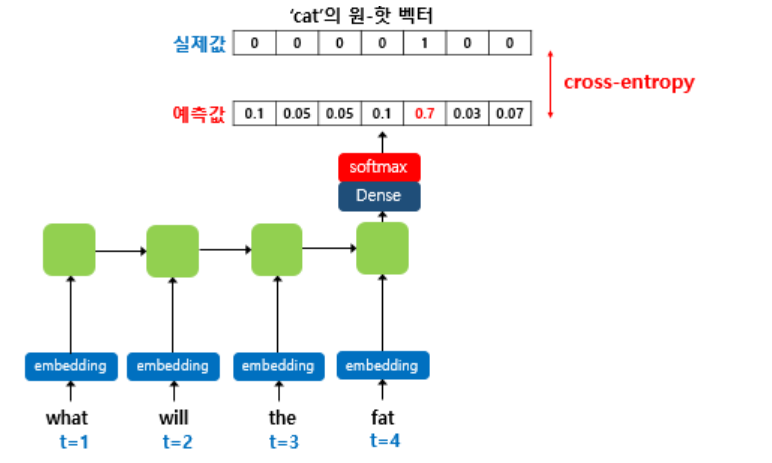

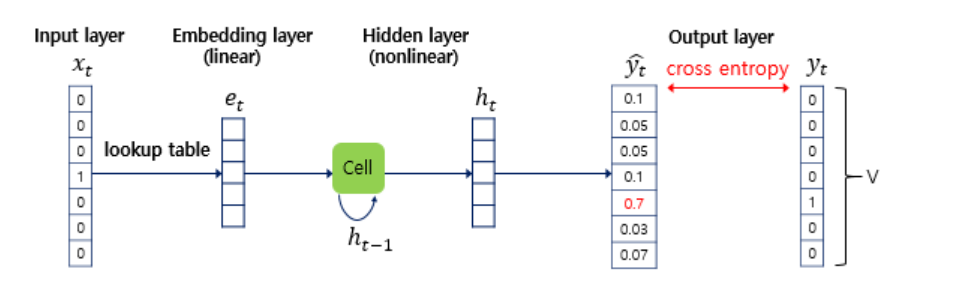

In [81]:
X  # 원핫 없는 정수 인덱스 상태의 문장 집합

array([[   0,    0,    0, ...,    0,    0,   99],
       [   0,    0,    0, ...,    0,   99,  269],
       [   0,    0,    0, ...,   99,  269,  371],
       ...,
       [   0,    0,    0, ...,  170,    8, 3493],
       [   0,    0,    0, ...,    8, 3493,  115],
       [   0,    0,    0, ..., 3493,  115,    2]])

In [82]:
vocab_size

3494

In [83]:
%%time
# Epoch 200/200
# 244/244 - 2s - 6ms/step - accuracy: 0.6067 - loss: 1.9442
# CPU times: total: 3min 38s
# Wall time: 6min 3s

embedding_dim = 10
hidden_units = 128
# vocab_size : 3494

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))   ## X data는 원핫 없이 바로 Embedding하였음 (OK)
model.add(LSTM(hidden_units))
model.add(Dense(vocab_size, activation='softmax'))  # 단어장의 모든 단어 중 하나 선택

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
244/244 - 5s - 20ms/step - accuracy: 0.0267 - loss: 7.6545
Epoch 2/200
244/244 - 3s - 12ms/step - accuracy: 0.0286 - loss: 7.1249
Epoch 3/200
244/244 - 3s - 12ms/step - accuracy: 0.0323 - loss: 6.9915
Epoch 4/200
244/244 - 3s - 13ms/step - accuracy: 0.0383 - loss: 6.8801
Epoch 5/200
244/244 - 3s - 14ms/step - accuracy: 0.0419 - loss: 6.7505
Epoch 6/200
244/244 - 3s - 14ms/step - accuracy: 0.0451 - loss: 6.6031
Epoch 7/200
244/244 - 3s - 14ms/step - accuracy: 0.0496 - loss: 6.4217
Epoch 8/200
244/244 - 3s - 14ms/step - accuracy: 0.0547 - loss: 6.2180
Epoch 9/200
244/244 - 3s - 14ms/step - accuracy: 0.0606 - loss: 6.0140
Epoch 10/200
244/244 - 3s - 14ms/step - accuracy: 0.0642 - loss: 5.8195
Epoch 11/200
244/244 - 3s - 14ms/step - accuracy: 0.0666 - loss: 5.6416
Epoch 12/200
244/244 - 3s - 14ms/step - accuracy: 0.0756 - loss: 5.4697
Epoch 13/200
244/244 - 4s - 15ms/step - accuracy: 0.0783 - loss: 5.3075
Epoch 14/200
244/244 - 4s - 15ms/step - accuracy: 0.0821 - loss: 5.1517
E

문장을 생성하는 함수 sentence_generation을 만들어서 문장을 생성해봅시다.

In [83]:
# test
current_word = 'i'
encoded = tokenizer.texts_to_sequences([current_word])[0]
print(encoded)
encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')
print(encoded)

[59]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 59]]


In [87]:
# 결과 예측
result = model.predict(encoded, verbose=0)
print(result.shape, result)
result = np.argmax(result, axis=1)
print(result)
tokenizer.index_word[result[0]]

(1, 3494) [[2.8714370e-10 5.7933114e-05 7.0812066e-06 ... 3.5681064e-17
  4.5554144e-10 1.5809055e-13]]
[310]


'want'

In [88]:
def sentence_generation(model, tokenizer, current_word, n): # 모델, 토크나이저, 현재 단어, 반복할 횟수
    init_word = current_word
    sentence = ''

    # n번 반복
    for _ in range(n):
        encoded = tokenizer.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=max_len-1, padding='pre')

        # 입력한 X(현재 단어)에 대해서 y를 예측하고 y(예측한 단어)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for word, index in tokenizer.word_index.items():
            # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
            if index == result:
                break

        # 현재 단어 + ' ' + 예측 단어를 현재 단어로 변경
        current_word = current_word + ' '  + word

        # 예측 단어를 문장에 저장
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence

임의의 단어 'i'에 대해서 10개의 단어를 추가 생성해봅시다.

In [ ]:
print(sentence_generation(model, tokenizer, 'i', 10))

i want to be rich and im not sorry clean an


임의의 단어 'how'에 대해서 10개의 단어를 추가 생성해봅시다.

In [90]:
print(sentence_generation(model, tokenizer, 'how', 10))

how to make facebook more accountable are art in a trade


In [91]:
print(sentence_generation(model, tokenizer, 'i', 2))

i want to


In [93]:
print(sentence_generation(model, tokenizer, 'she', 10))

she has a lot to say and say and say on


In [94]:
print(sentence_generation(model, tokenizer, 'people', 10))

people is wrong to focus on animal welfare when humans are


In [96]:
print(sentence_generation(model, tokenizer, 'peace', 10))

peace face metoo fallout to new york is lawyers will the
